***Installing Packages Needed for This Notebook and/or Beyond***

In [1]:
%pip install --upgrade pip
%pip install scipy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


***Import useful packages***

In [5]:
from functools import partial  # to make a multivalued function single valued

import numpy as np
import scipy.linalg, scipy.optimize

import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Exercise 1.1 1D Numerov algorithm for a finite harmonic well

### System
We define a potential well for a 1D system.

In [6]:
# def potential(x, c):
#     """
#     Potential well of depth c.
#     """
#     if 0. < x < 1.:
#         return c*x*(x-1.)
#     else:
#         return 0

def potential(x, c):
    """
    Potential well of depth c.
    """
    return np.where((0. < x) & (x < 1.), c * x * (x - 1.), 0)

In [7]:
#x = np.linspace(-1, 2, 1000)
#plt.plot(x, [potential(xx, 1) for xx in x])

The corresponding Numerov coefficient function $k(x)$ is

In [8]:
def numerov_coefficient_function(x, E, c):
    """
    The Numerov coefficient function k(x) for a given energy E
    and well depth c.
    """
    return 2.*(E - potential(x, c))

As the potential is non-zero only in the interval $[0, 1]$, it is sufficient to work in the range $[-dx, 1+dx]$.

In [9]:
dx = 0.01
n_steps = int(1/dx) + 2
x_values = np.linspace(-dx, 1+dx, n_steps)

### Numerov algorithm

We implement the numerov algorithm following the lecture notes. The algorithm should return the wavefunction $|\psi(x_i)\rangle$ at discrete $x_i \in [x_{min}, x_{max}]$ for a given Numerov coefficient function $k(x)$. Starting with two initial values $|\psi_0\rangle=|\psi(x_0)\rangle$ and $|\psi_1\rangle=|\psi(x_1)\rangle$, the algorithm iteratively calculates values $|\psi(x_i)\rangle$ for $i=2,...,n-1$. Note that this can be done starting from the left as well as from the right. Make sure to allow both directions, as we will make use of them in the shooting method later on.

In [10]:
def numerov(k, psi_0, psi_1, x_min, x_max, n_steps, right_to_left=False):
    """
    Perform the Numerov method on an interval starting with two initial values. 
    
    Parameters
    ----------
    k : function k = k(x), returning a number
        Numerov coefficient function.
    psi_0 : float or complex
        First initial wavefunction value.
    psi_1 : float or complex
        Second initial wavefunction value.
    x_min : float
        Left boundary of the interval of x values.
    x_max : float
        Right boundary of the interval of x values.
    n_steps : int
        Number of discrete x values in the interval.
    right_to_left : bool, default False
        When True, do Numerov steps from right to left, else from left to right.
    
    Returns
    -------
    array_like
        List of wavefunction values [psi_0, psi_1, psi_2, ..., psi_n].
    
    """
    #Create the x values
    x_values = np.linspace(x_min, x_max, n_steps)
    if right_to_left:
        x_values = x_values[::-1]
    
    #step size
    h = x_values[1] - x_values[0]
    
    #initialize the wavefunction array
    psi = np.zeros(n_steps, dtype=complex)
    psi[0] = psi_0
    psi[1] = psi_1
    
    
    #Numerov algorithm
    for i in range(1,n_steps-1):
        x_i = x_values[i]
        x_ip1 = x_values[i+1]
        x_im1 = x_values[i-1]
        
        k_i = k(x_i)
        k_ip1 = k(x_ip1)
        k_im1 = k(x_im1)
        
        psi[i + 1] = (2*(1-5*h**2/12* k_i) * psi[i] - (1 + h**2 / 12 * k_im1) * psi[i-1]) / (1 + h**2 / 12 * k_ip1)
                
    return psi

### Shooting method
The bidirectional shooting method integrates the Schroedinger equation for a given energy $E$ on $x_i \in [x_{min}, x_{max}]$ using the Numerov method once from the left and once from the right. \
The 2 solutions are then matched at a point $x_{min} \leq b \leq x_{max}$ for which $V(b)=E$. Choosing this point simplifies the matching condition as $\psi_L(b)''=\psi_R(b)''=0$. Make sure that your shooting method returns both the number of nodes of the resulting wavefunction and the difference of the logarithmic derivatives at $b$, $\frac{d\log\psi_L(x)}{dx}|_{x=b} - \frac{d\log\psi_R(x)}{dx}|_{x=b}$. This is necessary for the root finding method used to find bound states. Plus you could return the correctly matched and normalized wavefunction for later display.

In [11]:
def count_nodes(psi):
    """
    Counts number of nodes in the wavefunction psi. A sign change
    between neighboring psi values means there is a node in
    between.
    """
    n_nodes = np.sum([i*j < 0 for i, j in zip(psi, psi[1:])])
    return n_nodes

In [12]:
def bidirectional_shooting_method(E, c, x_min, x_max, n_steps, return_log_diff_only=False):
    """
    Bidirectional shooting method.
    
    Shoot wavefunctions with energy E from both the left and the right. Use
    the Numerov algorithm to get two solutions, one from the left and one
    from the right. Then match these two solutions at a point b, with 
    V(b) = E. In the search for a bound state, the difference of logarithmic
    derivatives at the matching point b will be the variable for which a 
    root finding method is applied.
    
    Parameters
    ----------
    E : float
        Energy of the wavefunction.
    c : float
        Well depth.
    x_min : float
        Left boundary of the interval of x values.
    x_max : float
        Right boundary of the interval of x values.
    n_steps : int
        Number of discrete x values in the interval.
    return_log_diff_only : bool, default False
        If True, return only the log derivative difference
        (needed for root finding).
        
    Returns
    -------
    psi : list
        Combined wavefunction.
    n_nodes : int
        Number of nodes of the wavefunction.
    d_log_diff : int
        Difference of the logarithmic derivatives of the two
        wavefunctions at the matching point.
    
    """
    x_values = np.linspace(x_min, x_max, n_steps)
    h = x_values[1] - x_values[0]
    
    #left shooting
    psi_left = numerov(partial(numerov_coefficient_function, E=E, c=c), 0, h, x_min, x_max, n_steps)
    
    #right shooting
    psi_right = numerov(partial(numerov_coefficient_function, E=E, c=c), 0, h, x_max, x_min, n_steps, right_to_left=True)
    
    #find matching point
    b_index = np.argmin(np.abs(potential(x_values, c) - E))
    b = x_values[b_index]
    
    #logarithmic derivative
    dpsi_left = (psi_left[b_index + 1] - psi_left[b_index - 1]) / (2*h)
    dpsi_right = (psi_right[b_index + 1] - psi_right[b_index - 1]) / (2*h)
    
    # dlog = dx/x
    log_deriv_left = dpsi_left / psi_left[b_index]
    log_deriv_right = dpsi_right / psi_right[b_index]
    
    d_log_diff = log_deriv_left - log_deriv_right
    
    if return_log_diff_only:
        return d_log_diff
    
    #Combine the two wavefunctions
    psi = np.zeros(n_steps, dtype=complex)
    psi[:b_index] = psi_left[:b_index]
    psi[b_index:] = psi_right[b_index:]
    
    #count the nodes
    n_nodes = count_nodes(psi)
    
    return psi, n_nodes, d_log_diff

## Problem analysis

Before tackling the problems of finding the number of bound states and finding actual states, let us analyze the implemented methods and how we should use them to find solutions to the Schroedinger equation (and understand what we're actually doing). For bound states, we're interested in finding the finite number of solutions at negative energies. Our potential well of depth $-c/4$ at $x_{min} = 1/2$ further narrows the range of possible solutions: states with energy less than $-c/4$ will not exist.

The shooting method tells us that we have found an eigenstate of the Schroedinger equation, if integrating with  Numerov gives the same solution if done from the left as well as from the right. The matching condition is simplified to one statement: if the log-derivative of the two solutions match at $b$ with $V(b)=E$, then $E$ is an eigenvalue and the solution an eigenstate.

So, we can restate the problem at the core of this exercise: for every energy $-c/4 \leq E \leq 0$, get the log-derivative difference at $b=b(E)=1/2+\sqrt{1/4 + E/c}$. Then search for all the roots of the log-derivative-differences. A root tells you that the energy is a solution.

Generally, before applying a root finder to find the roots of a function, we would like to get some understanding of the function: this will help us understand the solutions, and it will identify possible pitfalls during root finding. 

In the following figure (img/log_difference.png), you see the difference of logarithmic derivatives of the left and right solution as a function of energy for $c=400$:

![image](img/log_difference.png)

There are 4 roots, and the function is not continuous. So before finding a root using some root finding method, we need to define intervals for which only one root and no divergence exists: there, a root finder will converge to the correct root. How does the number of nodes for the results from the shooting method help you find such intervals?

## Part 1: number of bound states

We need to find the number of bound states for the potential well of depth $c$ for different values of $c \in (0, 1000]$. Looking at the figure from above: how many nodes has a solution for a given energy? How does this help you to find the number of bound states for a given well depth? 

In [13]:
def get_number_of_bound_states(c, x_values):
    """
    Get the number of bound states for a potential well of depth `c`.
    
    Parameters
    ----------
    c : float
        Well depth.
    x_values : array_like
        Discretized x values.
        
    Returns
    -------
    int
        Number of bound states for the potential well.
    
    """
    # we make use of the fact that the number of nodes (+1) of the 
    # state at zero energy is the number of bound states, so use
    # the shooting method to find a solution to zero energy
    psi, n_nodes, d_log_psi_diff = bidirectional_shooting_method(E=0, c=c, x_min=x_values[0], 
                                                                 x_max=x_values[-1], n_steps=len(x_values))
    
    # if the d_log_psi difference for zero energy is negative, 
    # the closest solution actually belongs to a positive energy
    # and is not a bound state anymore (take a look at the lonely
    # yellow dot in the figure above!)
    if d_log_psi_diff < 0:
        return n_nodes
    else:
        return n_nodes + 1

### Result
Use your function to plot the number of bound states vs well depth.

In [14]:
c_values = np.linspace(1, 1000, 500)
number_of_bound_states = np.zeros(len(c_values))
for i, c in enumerate(c_values):
    n_nodes = get_number_of_bound_states(c=c, x_values=x_values)
    number_of_bound_states[i] = n_nodes

/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_33738/3952373551.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  log_deriv_left = dpsi_left / psi_left[b_index]
/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_33738/3952373551.py:57: RuntimeWarning: invalid value encountered in scalar divide
  log_deriv_left = dpsi_left / psi_left[b_index]
/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_33738/3952373551.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  log_deriv_right = dpsi_right / psi_right[b_index]
/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_33738/3952373551.py:58: RuntimeWarning: invalid value encountered in scalar divide
  log_deriv_right = dpsi_right / psi_right[b_index]
/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_33738/3952373551.py:60: RuntimeWarning: invalid value encountered in scalar subtract
  d_log_diff = log_deriv_left - log_deriv_right


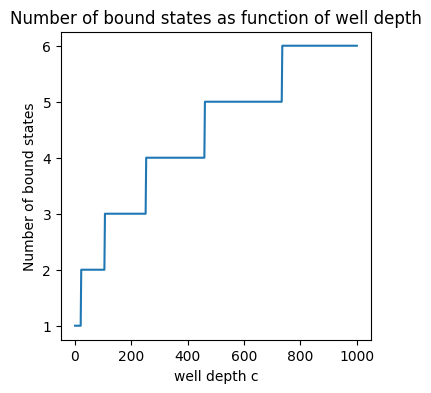

In [15]:
plt.figure(figsize=(4,4))
plt.plot(c_values, number_of_bound_states)
plt.title("Number of bound states as function of well depth")
plt.xlabel("well depth c")
plt.ylabel("Number of bound states")
plt.show()

## Part 2: bound states spectrum

Bound states exist only at discrete energies $E<0$. As discussed, we find them as the roots of the log-derivative-difference function. In order not to crash our root finding method, we should split the energy interval into subintervals, in which there is a single root and the log-derivative-difference is continuous. Then we use `scipy.optimize.bisect` to actually find this root.

In [16]:
def get_eigenenergy_for_n_nodes(n_nodes, c, x_values, tol=1e-6, maxiter=500):
    """
    Get the eigenenergy for an eigenstate with a certain number of nodes.
    
    Parameters
    ----------
    n_nodes : int
        Number of nodes.
    c : float
        Well depth.
    x_values : array_like
        Discrete x values.
    tol : float, default 1e-6
        Convergence tolerance for scipy.optimize.bisect.
    maxiter : int
        Maximum iterations to find energy subinterval.
        
    Returns
    -------
    float
        Eigenenergy of state with `n_nodes` nodes.
    
    """
    # write a function that finds the eigenenergy for 
    # a given number of nodes
    
    # Define a function that returns the number of nodes for a given energy
    def nodes_for_energy(E):
        _, n_nodes, _ = bidirectional_shooting_method(E=E, c=c, x_min=x_values[0], 
                                                      x_max=x_values[-1], n_steps=len(x_values))
        return n_nodes

    # Use bisect to find the energy corresponding to the desired number of nodes
    E_lower = -c / 4  # lower bound of energy (just above the bottom of the potential)
    E_upper = 0        # upper bound of energy (at zero energy)

    # Bisect method to find the root where nodes_for_energy equals n_nodes
    energy = scipy.optimize.bisect(lambda E: nodes_for_energy(E) - n_nodes, E_lower, E_upper, xtol=tol, maxiter=maxiter)
    
    return energy

### Result
Get all bound states for well depth $c=400$. First we find the number of bound states, then we will use the bisection method to find a wavefunction solution for $0, 1, ..., n - 1$ number of nodes. These solutions are then the bound states.

In [17]:
c = 400
number_of_bound_states = get_number_of_bound_states(c=c, x_values=x_values)
eigenenergies = []
wavefunctions = []
for n in range(number_of_bound_states):
    # Find the energy for the nth state (nodes)
    energy = get_eigenenergy_for_n_nodes(n_nodes=n, c=c, x_values=x_values)
    
    # Solve the Schrödinger equation for this energy using bidirectional shooting
    psi, _, _ = bidirectional_shooting_method(E=energy, c=c, x_min=x_values[0], x_max=x_values[-1], 
                                              n_steps=len(x_values))
    
    eigenenergies.append(energy)
    wavefunctions.append(psi)


/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_33738/3952373551.py:57: RuntimeWarning: divide by zero encountered in scalar divide
  log_deriv_left = dpsi_left / psi_left[b_index]
/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_33738/3952373551.py:57: RuntimeWarning: invalid value encountered in scalar divide
  log_deriv_left = dpsi_left / psi_left[b_index]
/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_33738/3952373551.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  log_deriv_right = dpsi_right / psi_right[b_index]
/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_33738/3952373551.py:58: RuntimeWarning: invalid value encountered in scalar divide
  log_deriv_right = dpsi_right / psi_right[b_index]
/var/folders/x0/zx3zh2g96tvbvblvgctx16n00000gn/T/ipykernel_33738/3952373551.py:60: RuntimeWarning: invalid value encountered in scalar subtract
  d_log_diff = log_deriv_left - log_deriv_right


/Users/leonardodelgaudio/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/leonardodelgaudio/opt/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/leonardodelgaudio/opt/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:5620: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice


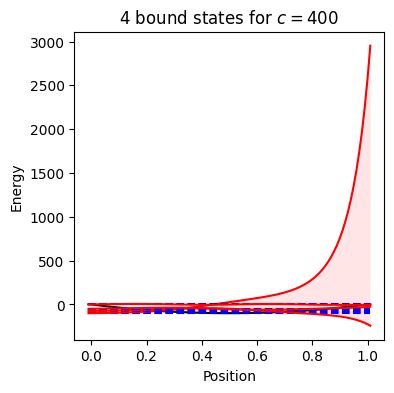

In [18]:
plt.figure(figsize=(4,4))
# plot the potential
plt.plot(x_values, [potential(x, c=c) for x in x_values], c='k')

for i, energy in enumerate(eigenenergies):
    # plot the energy level and the wavefunction centered at the
    # energy level
    energy_level = np.repeat(energy, len(x_values))
    plt.plot(x_values, energy_level, '--', c='b')
    # to make the wavefunctions nicely visible
    scaling = 1.5 * c / 4 / number_of_bound_states
    psi_at_energy_level = energy_level + scaling * wavefunctions[i]
    plt.plot(x_values, psi_at_energy_level, '-', c='r')
    plt.fill_between(x_values, psi_at_energy_level, energy_level, facecolor='red', alpha=0.1)

plt.title(f"${number_of_bound_states}$ bound states for $c={c}$")
plt.xlabel("Position")
plt.ylabel("Energy")
plt.show()